In [66]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Tensors

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [6]:
matrix = tf.constant([[1., 2., 3.], [4., 5., 6.]])
print(matrix.shape)
print(matrix.dtype)

(2, 3)
<dtype: 'float32'>


Types conflicts

In [7]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [8]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

There are more various types of tensors, in order to check them look to documentation.

### Custom loss functions

California Housing dataset

In [10]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Implementing Huber loss function

In [11]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

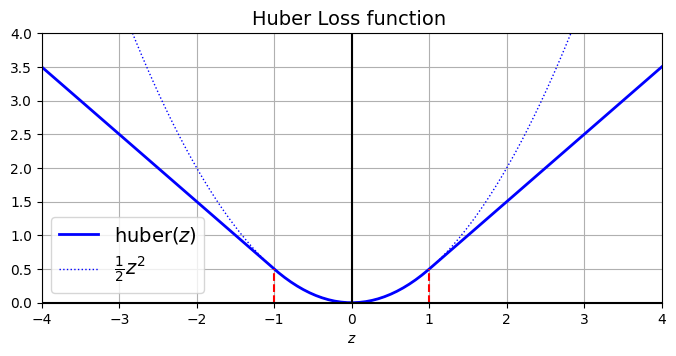

In [14]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber Loss function ", fontsize=14)
plt.show()

In [15]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [17]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.5462 - mae: 0.8989 - val_loss: 0.2566 - val_mae: 0.5458
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2099 - mae: 0.5024 - val_loss: 0.2078 - val_mae: 0.4913


### Saving/Loading model with custom function

In [18]:
model.save("model_with_huber.h5")

In [19]:
model = keras.models.load_model("model_with_huber.h5",
                                custom_objects={"huber_fn": huber_fn})

In [20]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2012 - mae: 0.4902 - val_loss: 0.2022 - val_mae: 0.4827
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1968 - mae: 0.4837 - val_loss: 0.1789 - val_mae: 0.4585


Model with non-standard parameter

In [21]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [22]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [23]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.2181 - mae: 0.4835 - val_loss: 0.2023 - val_mae: 0.4575
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2144 - mae: 0.4795 - val_loss: 0.2109 - val_mae: 0.4584


In [24]:
model.save("model_with_huber_with_non_standard_parameter.h5")

In [25]:
model = keras.models.load_model("model_with_huber_with_non_standard_parameter.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [26]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2105 - mae: 0.4748 - val_loss: 0.2020 - val_mae: 0.4559
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2085 - mae: 0.4723 - val_loss: 0.2430 - val_mae: 0.4773


Alternative way

In [27]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [29]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [30]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.7702 - mae: 0.9229 - val_loss: 0.4871 - val_mae: 0.6283
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2513 - mae: 0.5162 - val_loss: 0.4054 - val_mae: 0.5760


In [31]:
model.save("model_wtih_huber_with_class_to_non_standard_parameter.h5")

In [32]:
model = keras.models.load_model("model_wtih_huber_with_class_to_non_standard_parameter.h5", 
                               custom_objects={"HuberLoss": HuberLoss})

In [33]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.2369 - mae: 0.5018 - val_loss: 0.3271 - val_mae: 0.5303
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2289 - mae: 0.4955 - val_loss: 0.2729 - val_mae: 0.5000


In [34]:
model.loss.threshold

2.0

### Other custom functions

In [35]:
def my_softplus(z): # return value is tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [36]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [37]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [38]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 2.1076 - mae: 0.9678 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.6951 - mae: 0.5190 - val_loss: inf - val_mae: inf


In [39]:
model.save("model_with_many_custom_functions.h5")

In [40]:
model = keras.models.load_model(
    "model_with_many_custom_functions.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": lambda: my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

Making custom functions that need parameter \
Moreover we have to inicialize:
 - __call__ for regularization, inicialization and constraint
 - call() for loss function, layer and activation function

In [41]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [43]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.9128 - mae: 0.8801 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.7449 - mae: 0.5240 - val_loss: inf - val_mae: inf


In [44]:
model.save("model_with_many_custom_function_and_non_standard_parameter.h5")

In [45]:
model = keras.models.load_model(
    "model_with_many_custom_function_and_non_standard_parameter.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": lambda: my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

### Streaming metrics

In [46]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [48]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 1ms/step - loss: 0.3765 - HuberMetric: 0.7558
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1190 - HuberMetric: 0.2388


In [49]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.3765081763267517, 0.3765082937120107)

In [50]:
model.save("model_with_custom_stream_metric.h5")

In [51]:
model = keras.models.load_model("model_with_custom_stream_metric.h5",      
                               custom_objects={"HuberMetric": HuberMetric})

In [52]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2313 - HuberMetric: 0.2313
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2205 - HuberMetric: 0.2205


### Custom Layers

In [53]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # musi być na końcu

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [54]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [55]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 1.5418 - val_loss: 1.0169
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.4732


0.47323793172836304

In [56]:
model.save("model_With_custom_layers.h5")

In [57]:
model = keras.models.load_model("model_With_custom_layers.h5",
                                custom_objects={"MyDense": MyDense})

### Custom models

In [58]:
X_new_scaled = X_test_scaled

Define new layer

In [59]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.n_layers = n_layers                                     
        self.n_neurons = n_neurons                                   
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
    
    def get_config(self):                                               
        base_config = super().get_config()                              
        return {**base_config,                                          
                "n_layers": self.n_layers, "n_neurons": self.n_neurons} 

Define new model

In [60]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim                                 
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    def get_config(self):                                            
        base_config = super().get_config()                           
        return {**base_config,                                       
                "output_dim": self.output_dim}                       

In [61]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 4s 2ms/step - loss: 11.0623
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.2957
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 4.0356
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 2.0732
Epoch 5/5
162/162 [==============================] - 0s 1ms/step
